In [ ]:
USER INPUT
   ↓
llm_router
   ↓
agent_choice →────────────┐
                          │
   ┌────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────┐
   ↓                                                            ↓                                                            ↓                                                            ↓
agent_summ                                                general_agent                                               loan_agent                                                  mail_agent
   │                                                            │                                                            │                                                            │
   ↓                                                            ↓                                                            ↓                                                            ↓
cypher_query_generator                                   cypher_query_generator                                   cypher_query_generator                                   cypher_query_generator
   ↓                                                            ↓                                                            ↓                                                            ↓
neo4j_retriever                                           neo4j_retriever                                           neo4j_retriever                                           neo4j_retriever
   ↓                                                            ↓                                                            ↓                                                            ↓
review_reflector? (optional retry loop)                      (skip)                                                       (skip)                                                       (skip)
   ↓                                                            ↓                                                            ↓                                                            ↓
agent_summ                                                general_agent                                               loan_agent (→ call loan approval API)                      mail_content_generator (LLM-based)
   ↓                                                            ↓                                                            ↓                                                            ↓
                                                           final response                                             justification (LLM-generated)                                send_mail (loop over customers)
                                                                                                                             ↓                                                            ↓
                                                                                                                             END                                                         END


In [9]:
# --- Imports ---
from langgraph.graph import StateGraph
from langgraph.graph.message import MessageGraph
from typing import TypedDict, List, Literal, Dict, Optional
from langchain_core.runnables import Runnable
from langchain_core.messages import AIMessage, HumanMessage
from operator import itemgetter

# --- State Definition ---
class AgentState(TypedDict):
    user_input: str
    agent_choice: Optional[str]
    neo4j_query: Optional[str]
    neo4j_result: Optional[List[Dict]]
    api_response: Optional[Dict]
    final_response: Optional[str]
    error: Optional[str]

# --- Placeholder Tools & LLMs ---
llm = ...  # Your LLM instance
def neo4j_tool(query): ...  # Your Neo4j DB executor
def send_mail_tool(email, content): ...  # Your SMTP or API sender
def loan_approval_api(customer_data): ...  # External loan decision service

# --- Core Nodes ---
def llm_router(state: AgentState):
    prompt = f"""Decide which agent to route the following query to:
    "{state['user_input']}"
    Options: agent_summ, general_agent, loan_agent, mail_agent
    """
    agent_choice = llm.invoke(prompt).strip().lower()
    return {"agent_choice": agent_choice}

def cypher_query_generator(state: AgentState):
    prompt = f"""Generate a Cypher query for this request:
    "{state['user_input']}"
    """
    query = llm.invoke(prompt).strip()
    return {"neo4j_query": query}

def neo4j_retriever(state: AgentState):
    try:
        result = neo4j_tool(state['neo4j_query'])
        return {"neo4j_result": result}
    except Exception as e:
        return {"error": str(e)}

def review_reflector(state: AgentState):
    if state.get("error"):
        # Retry query generation
        return cypher_query_generator(state)
    return {}

def agent_summ(state: AgentState):
    reviews = state["neo4j_result"]
    prompt = f"""Summarize and suggest improvements based on these reviews:
    {reviews}
    """
    response = llm.invoke(prompt)
    return {"final_response": response}

def general_agent(state: AgentState):
    context = state["neo4j_result"]
    prompt = f"""Based on this data, respond to the query:
    Query: {state['user_input']}
    Data: {context}
    """
    response = llm.invoke(prompt)
    return {"final_response": response}

def loan_agent(state: AgentState):
    customer_data = state["neo4j_result"]
    api_result = loan_approval_api(customer_data)
    prompt = f"""Given:
    Customer: {customer_data}
    API Result: {api_result}
    Generate a decision explanation.
    """
    response = llm.invoke(prompt)
    return {"api_response": api_result, "final_response": response}

# --- Mail Agent Branching ---
def mail_intent_classifier(state: AgentState):
    prompt = f"""Classify the intent of this mail request:
    "{state['user_input']}"
    Reply with one of: 'min_balance', 'product_ad'
    """
    result = llm.invoke(prompt).strip().lower()
    return result

def generate_min_balance_email(state: AgentState):
    customers = state["neo4j_result"]
    emails = []
    for cust in customers:
        prompt = f"""
        Write a balance alert email to:
        Name: {cust['name']}, Email: {cust['email']}
        """
        content = llm.invoke(prompt)
        emails.append({"email": cust["email"], "content": content})
    return {"emails_to_send": emails}

def generate_product_ad_email(state: AgentState):
    customers = state["neo4j_result"]
    emails = []
    for cust in customers:
        prompt = f"""
        Write a promotional email to:
        Name: {cust['name']}, Email: {cust['email']}
        """
        content = llm.invoke(prompt)
        emails.append({"email": cust["email"], "content": content})
    return {"emails_to_send": emails}

def send_mail(state: AgentState):
    for email_data in state["emails_to_send"]:
        send_mail_tool(email_data["email"], email_data["content"])
    return {"final_response": "Emails sent successfully."}

# --- Build Graph ---
workflow = StateGraph(AgentState)
workflow.set_entry_point("llm_router")

# Add nodes
workflow.add_node("llm_router", llm_router)
workflow.add_node("cypher_query_generator", cypher_query_generator)
workflow.add_node("neo4j_retriever", neo4j_retriever)
workflow.add_node("review_reflector", review_reflector)
workflow.add_node("agent_summ", agent_summ)
workflow.add_node("general_agent", general_agent)
workflow.add_node("loan_agent", loan_agent)
workflow.add_node("mail_intent_classifier", mail_intent_classifier)
workflow.add_node("generate_min_balance_email", generate_min_balance_email)
workflow.add_node("generate_product_ad_email", generate_product_ad_email)
workflow.add_node("send_mail", send_mail)

# Add core routing logic
workflow.add_conditional_edges("llm_router", lambda s: s["agent_choice"], {
    "agent_summ": "cypher_query_generator",
    "general_agent": "cypher_query_generator",
    "loan_agent": "cypher_query_generator",
    "mail_agent": "cypher_query_generator"
})

# Shared data retrieval
workflow.add_edge("cypher_query_generator", "neo4j_retriever")

# Summarization agent with reflector retry
workflow.add_conditional_edges("neo4j_retriever", lambda s: s.get("agent_choice"), {
    "agent_summ": "review_reflector",
    "general_agent": "general_agent",
    "loan_agent": "loan_agent",
    "mail_agent": "mail_intent_classifier"
})
workflow.add_edge("review_reflector", "agent_summ")

# Mail intent split
workflow.add_conditional_edges("mail_intent_classifier", mail_intent_classifier, {
    "min_balance": "generate_min_balance_email",
    "product_ad": "generate_product_ad_email"
})
workflow.add_edge("generate_min_balance_email", "send_mail")
workflow.add_edge("generate_product_ad_email", "send_mail")

# Set final output point
workflow.set_finish_point("send_mail")
workflow.set_finish_point("agent_summ")
workflow.set_finish_point("general_agent")
workflow.set_finish_point("loan_agent")

# Compile it
graph = workflow.compile()


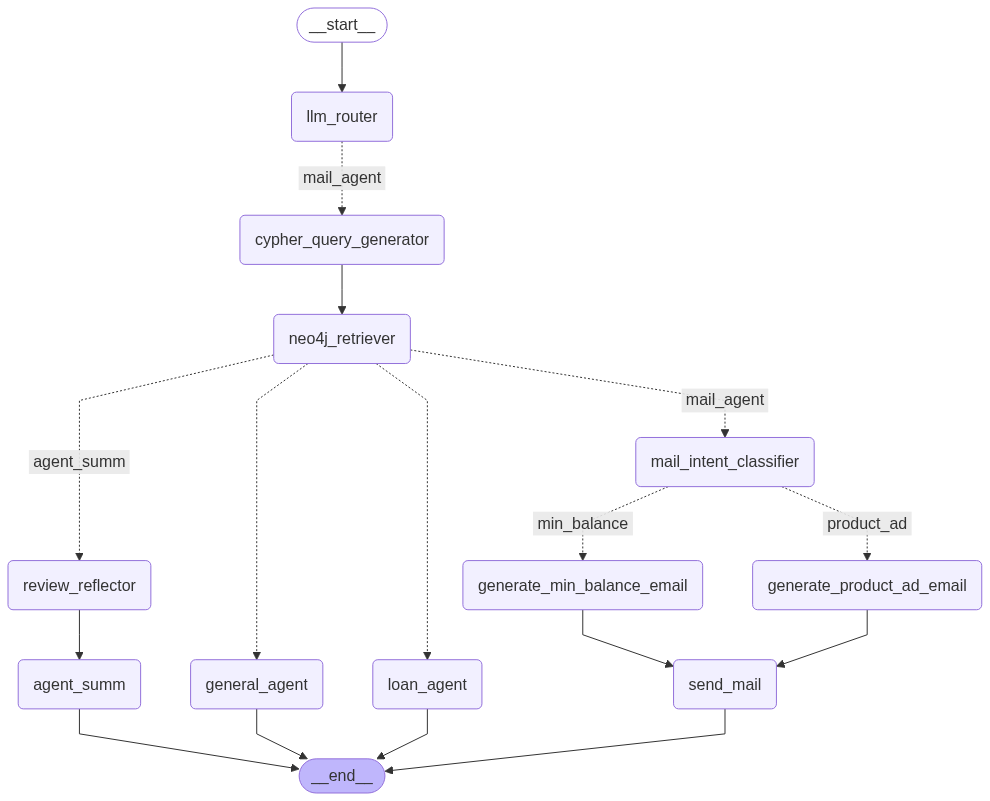

In [10]:
# View
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

“Why not remove the first conditional at llm_router, and instead, always go to cypher_query_generator → neo4j_retriever, and only apply conditional routing after data is retrieved?”

🤔 Are There Any Drawbacks?
Only one minor point:

If in the future, some agents don’t require Neo4j, then forcing every query through cypher_query_generator → neo4j_retriever may become inefficient.